# vdl Depth and Class Constrained Diffusion
- **Name:** Nils Fahrni
- **Date:** 07.01.2025

## Dataset Preparation

- 894 classes

In [1]:
from data.nyuv2 import NYUDepthV2
from torchvision import transforms
from torch.utils.data import DataLoader

image_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((1.3268, 1.1391, 1.0176), (0.5704, 0.5411, 0.5077))
])

crop_t = transforms.Compose([
    transforms.CenterCrop(400)
])

dataset = NYUDepthV2(root='data', download=True, preload=False, image_transform=image_t, seg_transform=crop_t, depth_transform=crop_t)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

Dataset already exists, skipping download.


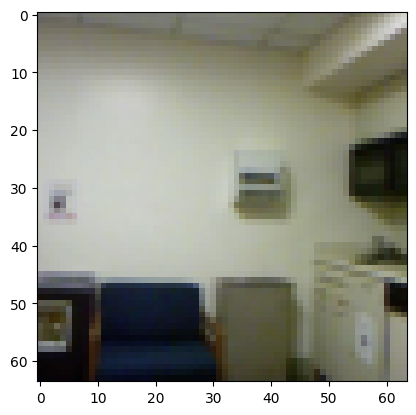

In [2]:
import torch
import matplotlib.pyplot as plt

def unnormalize(img):
    mean = torch.tensor([1.3268, 1.1391, 1.0176]).view(-1, 1, 1)  # Reshape to [C, 1, 1]
    std = torch.tensor([0.5704, 0.5411, 0.5077]).view(-1, 1, 1)    # Reshape to [C, 1, 1]
    img = std * img + mean
    img = torch.clip(img, 0, 1)
    return img

plt.imshow(unnormalize(dataset[0][0]).permute(1, 2, 0))

## Modules

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output


class UNet_conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.class_emb = nn.Linear(num_classes, time_dim)
            self.depth_emb = nn.Linear(num_classes, time_dim)
            self.t_proj = nn.Linear(3 * time_dim, time_dim)  # Project concatenated embeddings back to time_dim

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, class_vector, depth_vector):
        # Process time embedding
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        # Process class and depth embeddings
        class_emb = self.class_emb(class_vector)
        depth_emb = self.depth_emb(depth_vector)

        # Combine embeddings
        t_combined = torch.cat([t, class_emb, depth_emb], dim=-1)
        t_combined = self.t_proj(t_combined)

        x1 = self.inc(x)
        x2 = self.down1(x1, t_combined)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t_combined)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t_combined)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t_combined)
        x = self.sa4(x)
        x = self.up2(x, x2, t_combined)
        x = self.sa5(x)
        x = self.up3(x, x1, t_combined)
        x = self.sa6(x)
        output = self.outc(x)
        return output

net = UNet_conditional(num_classes=894, device="cpu")
print(f"Total parameters: {sum(p.numel() for p in net.parameters())}")

# Dummy inputs
x = torch.randn(3, 3, 64, 64)
t = torch.randint(0, 1000, (x.shape[0],))
class_vector = torch.zeros((x.shape[0], 894))
depth_vector = torch.zeros((x.shape[0], 894))

# Forward pass
output = net(x, t, class_vector, depth_vector)
print(f"Output shape: {output.shape}")

Total parameters: 23987843
Output shape: torch.Size([3, 3, 64, 64])


## Diffusion

In [4]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
import logging

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x




## Trainer

In [5]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import copy
import os
import wandb

class Trainer:
    def __init__(self, model, diffusion, optimizer, epochs, device, train_dataloader, val_dataloader=None, run_name='diffusion_model', project_name='diffusion_project', save_dir='models', ema_decay=0.995):
        self.model = model.to(device)
        self.diffusion = diffusion
        self.optimizer = optimizer
        self.epochs = epochs
        self.device = device
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.run_name = run_name
        self.project_name = project_name
        self.save_dir = save_dir
        self.ema_decay = ema_decay

        # Initialize EMA
        self.ema = EMA(ema_decay)
        self.ema_model = copy.deepcopy(model).eval().requires_grad_(False)

        # Initialize Weights & Biases
        wandb.init(project=self.project_name, name=self.run_name)
        self.run_id = wandb.run.id
        self.best_val_loss = float('inf')

        # Create a models directory if it doesn't exist
        os.makedirs(self.save_dir, exist_ok=True)

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss = 0
            pbar = tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}/{self.epochs}")
            for i, (images, segs, depths, class_vectors, depth_vectors) in enumerate(pbar):
                images = images.to(self.device)
                class_vectors = class_vectors.to(self.device)
                depth_vectors = depth_vectors.to(self.device)

                # Sample time steps
                t = self.diffusion.sample_timesteps(images.size(0)).to(self.device)

                # Add noise to images
                x_t, noise = self.diffusion.noise_images(images, t)

                # Implement classifier-free guidance by dropping conditional vectors randomly
                if torch.rand(1).item() < 0.1:
                    class_vectors = None
                    depth_vectors = None

                # Predict noise using the model
                predicted_noise = self.model(x_t, t, class_vectors, depth_vectors)

                # Compute loss
                loss = F.mse_loss(predicted_noise, noise)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Update EMA model
                self.ema.step_ema(self.ema_model, self.model)

                epoch_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})

                # Log the loss
                wandb.log({'train_loss': loss.item()})

            avg_loss = epoch_loss / len(self.train_dataloader)
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {avg_loss:.4f}")

            # Validate and save the model
            if self.val_dataloader is not None:
                val_loss = self.validate()
                wandb.log({'val_loss': val_loss})
                self._save_model(val_loss)
            else:
                self._save_model(avg_loss)

    def validate(self):
        self.model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, segs, depths, class_vectors, depth_vectors in self.val_dataloader:
                images = images.to(self.device)
                class_vectors = class_vectors.to(self.device)
                depth_vectors = depth_vectors.to(self.device)

                t = self.diffusion.sample_timesteps(images.size(0)).to(self.device)
                x_t, noise = self.diffusion.noise_images(images, t)

                predicted_noise = self.model(x_t, t, class_vectors, depth_vectors)
                loss = F.mse_loss(predicted_noise, noise)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(self.val_dataloader)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        return avg_val_loss

    def _save_model(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            model_name = f"{self.model.__class__.__name__}_{self.run_id}.pth"
            save_path = os.path.join(self.save_dir, model_name)
            torch.save(self.model.state_dict(), save_path)
            wandb.save(save_path)
            print(f"Model saved to {save_path} with val_loss {val_loss:.4f}")

    def sample(self, n_samples, class_vectors, depth_vectors, cfg_scale=3):
        self.model.eval()
        with torch.no_grad():
            x = torch.randn((n_samples, 3, self.diffusion.img_size, self.diffusion.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.diffusion.noise_steps)), desc='Sampling'):
                t = torch.full((n_samples,), i, dtype=torch.long).to(self.device)
                predicted_noise = self.model(x, t, class_vectors, depth_vectors)
                if cfg_scale > 0:
                    uncond_predicted_noise = self.model(x, t, None, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.diffusion.alpha[t][:, None, None, None]
                alpha_hat = self.diffusion.alpha_hat[t][:, None, None, None]
                beta = self.diffusion.beta[t][:, None, None, None]
                noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
                x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise) + torch.sqrt(beta) * noise
            x = (x.clamp(-1, 1) + 1) / 2  # Rescale images to [0, 1]
            x = (x * 255).type(torch.uint8)  # Convert to uint8
            return x


In [6]:
epochs = 1
batch_size = 8
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Initialize model
num_classes = 894
model = UNet_conditional(num_classes=num_classes, device=device)

# Initialize diffusion process
diffusion = Diffusion(img_size=64, device=device)

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Initialize trainer
trainer = Trainer(
    model=model,
    diffusion=diffusion,
    optimizer=optimizer,
    epochs=epochs,
    device=device,
    train_dataloader=train_loader,
    run_name='nyu_depth_diffusion',
    project_name='vdl',
    save_dir='models'
)

# Start training
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: okaynils. Use `wandb login --relogin` to force relogin


Epoch 1/1:   0%|          | 0/182 [00:00<?, ?it/s]

In [10]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)

pbar = tqdm(dataloader, desc=f"yo")
for i, (images, segs, depths, class_vectors, depth_vectors) in enumerate(pbar):
    print(images.shape, segs.shape, depths.shape, class_vectors.shape, depth_vectors.shape)

yo:   8%|▊         | 1/12 [00:04<00:48,  4.37s/it]

torch.Size([128, 3, 64, 64]) torch.Size([128, 400, 400]) torch.Size([128, 400, 400]) torch.Size([128, 894]) torch.Size([128, 894])


yo:  17%|█▋        | 2/12 [00:08<00:43,  4.32s/it]

torch.Size([128, 3, 64, 64]) torch.Size([128, 400, 400]) torch.Size([128, 400, 400]) torch.Size([128, 894]) torch.Size([128, 894])


yo:  17%|█▋        | 2/12 [00:12<01:00,  6.02s/it]


KeyboardInterrupt: 